# License Plate Recognition (Character Recognition) using OpenCV and CNN

### Project by Team 2

### Importing Necessary Libraries

In [1]:
import cv2
import imutils
import pytesseract
import os
import inspect
import numpy as np
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, Bidirectional
import functools
from sklearn.metrics import f1_score
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [2]:
#inspect.getfile(pytesseract)

In [3]:
#pytesseract.pytesseract.tesseract_cmd = 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\pytesseract\\__init__.py'

### Checking Image Charactistics 

In [4]:
image_input = cv2.imread('D:\BAN 676-Deep Learning\Project\Data\image_licenseplate3.jpeg')
ht, wdh = image_input.shape[:2]
print(ht)
print(wdh)

600
800


In [5]:
image_input = imutils.resize(image_input, width=400)

In [6]:
cv2.imshow("Image_Original", image_input)
#cv2.waitKey(0)

In [7]:
image_grey = cv2.cvtColor(image_input, cv2.COLOR_BGR2GRAY)
cv2.imshow("Image_Grey", image_grey)
#cv2.waitKey(0)

## Preprocessing the image

In [8]:
thresh_otsu, _ = cv2.threshold(image_grey, 0, 255, cv2.THRESH_OTSU)
thresh_triangle, _ = cv2.threshold(image_grey, 0, 255, cv2.THRESH_TRIANGLE)
thresh_manual = np.median(image_grey)

def input_thresh(threshold, sigma=0.33):
    return (1-sigma) * threshold, (1+sigma) * threshold

thresh_otsu = input_thresh(thresh_otsu)
thresh_triangle = input_thresh(thresh_triangle)
thresh_manual = input_thresh(thresh_manual)

print(f"Otsu's Threshold: {thresh_otsu} \nTriangle Threshold: {thresh_triangle} \nManual Threshold: {thresh_manual}")

Otsu's Threshold: (83.74999999999999, 166.25) 
Triangle Threshold: (60.3, 119.7) 
Manual Threshold: (81.07, 160.93)


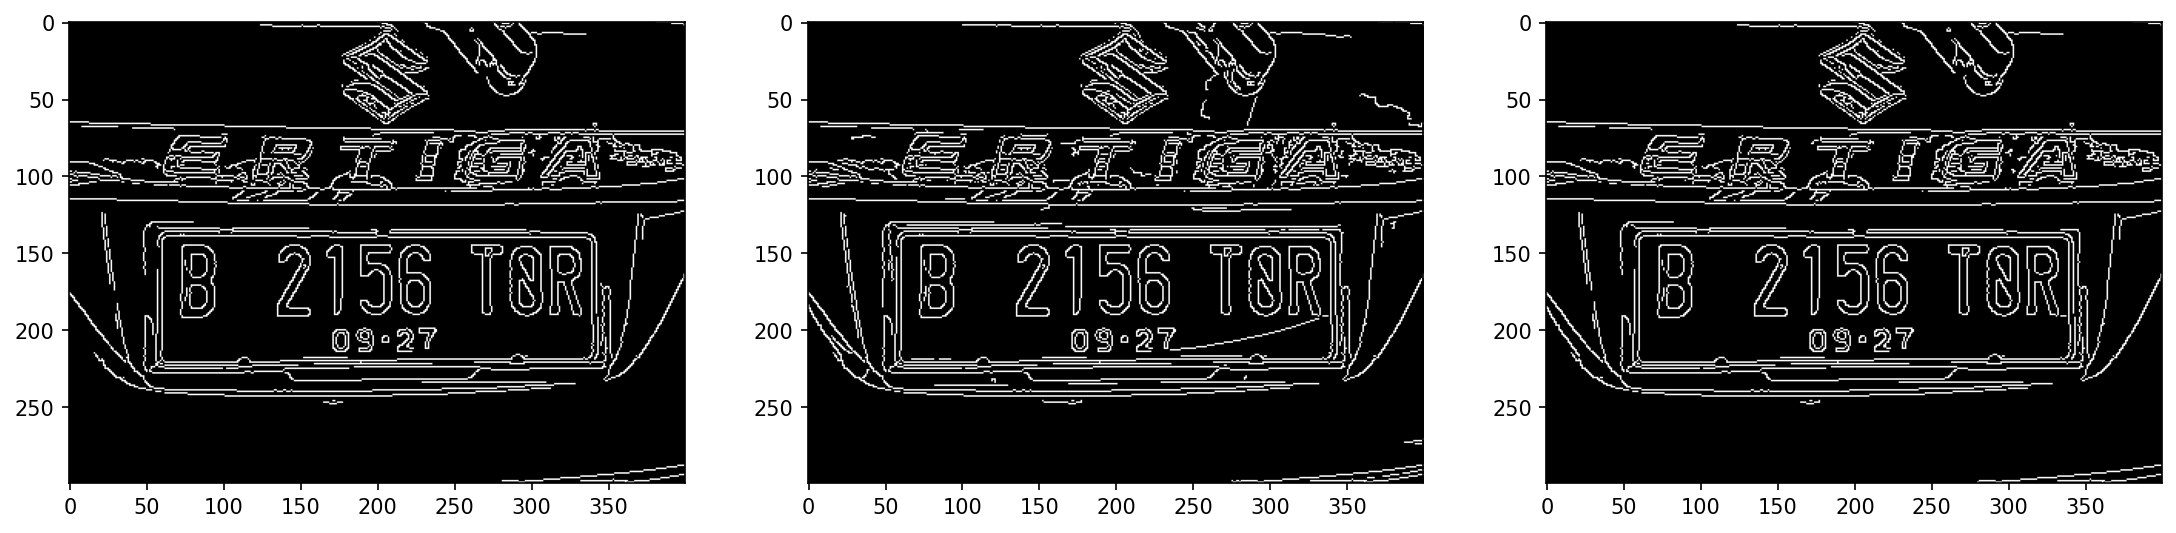

In [9]:
edge_otsu = cv2.Canny(image_grey, *thresh_otsu)
edge_triangle = cv2.Canny(image_grey, *thresh_triangle)
edge_manual = cv2.Canny(image_grey, *thresh_manual)

fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
ax[0].imshow(edge_otsu, cmap='gray')
ax[1].imshow(edge_triangle, cmap='gray')
ax[2].imshow(edge_manual, cmap='gray')

In [10]:
image_edged = cv2.Canny(image_grey, 72, 142) 
cv2.imshow("Image_Edged", image_edged)
#cv2.waitKey(0)

In [11]:
contours, hierarchy = cv2.findContours(image_edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# draw contours on the original image for `CHAIN_APPROX_SIMPLE`
image_input_cnt = image_input.copy()
cv2.drawContours(image_input_cnt, contours, -1, (0, 255, 0), 2, cv2.LINE_AA)
# see the results
cv2.imshow('Image_Contours', image_input_cnt)
#cv2.waitKey(0)


In [12]:
cnts = sorted(contours, key = cv2.contourArea, reverse = True) [:2]
platecnt = None
image_input_cnt2 = image_input.copy()
cv2.drawContours(image_input_cnt2,cnts,-1,(0,255,0),3)
cv2.imshow("Top 2 contours",image_input_cnt2)
#cv2.waitKey(0)

In [13]:
i='Cropped'
for c in cnts:
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
        if len(approx) == 4: 
                platecnt = approx

        x,y,w,h = cv2.boundingRect(c) 
        image_plate=image_input[y:y+h,x:x+w]
        cv2.imwrite((i)+'.png',image_plate)
        break

In [14]:
cv2.drawContours(image_input, [platecnt], -1, (0, 255, 0), 3)
cv2.imshow("Detected license plate", image_input)
#cv2.waitKey(0)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2599: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'


In [15]:
License_Plate = 'Cropped.png'
cv2.imshow("cropped", cv2.imread(License_Plate))
#plate = pytesseract.image_to_string(Cropped_loc, lang='eng')
#print("Number plate is:", plate)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [16]:
image_plate = cv2.imread('/Users/valli/Cropped.png')

In [17]:
image_plate = cv2.resize(image_plate, (333, 75))
image_grey_plate = cv2.cvtColor(image_plate, cv2.COLOR_BGR2GRAY)
_, image_binary_plate = cv2.threshold(image_grey_plate, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#image_binary_plate = cv2.erode(img_binary_lp, (3,3))
#image_binary_plate = cv2.dilate(img_binary_lp, (3,3))
    
    

In [18]:
print(image_binary_plate.shape)


(75, 333)


In [19]:
image_binary_plate[0:4,:] = 255
image_binary_plate[:,0:4] = 255
image_binary_plate[72:,:] = 255
image_binary_plate[:,330:] = 255


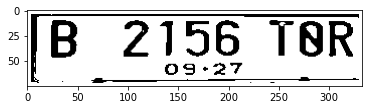

True

In [20]:
LP_WIDTH = image_binary_plate.shape[0]
LP_HEIGHT = image_binary_plate.shape[1]


limits = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
plt.imshow(image_binary_plate, cmap='gray')
plt.show()
cv2.imwrite('Cropped_grey.jpg',image_binary_plate)

In [21]:
print(limits)

[12.5, 37.5, 33.3, 222.0]


In [22]:
# Find all contours in the image
contours, _  = cv2.findContours(image_binary_plate.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Retrieve potential dimensions
width_lowerlimit = limits[0]
width_upperlimit = limits[1]
height_lowerlimit = limits[2]
height_upperlimit = limits[3]
    
# Check largest 5 or  15 contours for license plate or character respectively
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    
image_plate_grey = cv2.imread('Cropped_grey.jpg')
    


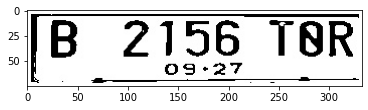

In [23]:
cntr_list = []
target_contours = []
ch_seg = []
for c in cntr_list:
    # detects contour in binary image and returns the coordinates of rectangle enclosing it
    intX, intY, intWidth, intHeight = cv2.boundingRect(c)
        
    # checking the dimensions of the contour to filter out the characters by contour's size
    if intWidth > width_lowerlimit and intWidth < width_upperlimit and intHeight > height_lowerlimit and intHeight < height_upperlimit :
        cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

        char_copy = np.zeros((44,24))
        # extracting each character using the enclosing rectangle's coordinates.
        char = image_binary_plate[intY:intY+intHeight, intX:intX+intWidth]
        char = cv2.resize(char, (20, 40))
        
            
        cv2.rectangle(image_plate_grey, (intX,intY), (intWidth+intX, intY+intHeight), (255,0,0), 2)
        #plt.imshow(image_plate_grey, cmap='gray')

        # Make result formatted for classification: invert colors
        char = cv2.subtract(255, char)
        # Resize the image to 24x44 with black border
        char_copy[2:42, 2:22] = char
        char_copy[0:2, :] = 0
        char_copy[:, 0:2] = 0
        char_copy[42:44, :] = 0
        char_copy[:, 22:24] = 0
        
        ch_seg.append(char_copy)
plt.imshow(image_plate_grey, cmap='gray')

            

In [24]:
# arbitrary function that stores sorted list of character indices
indices = sorted(range(len(cntr_list)), key=lambda k: cntr_list[k])
ch_seg_copy = []
for idx in indices:
    ch_seg_copy.append(ch_seg[idx])# stores character images according to their index
ch_seg = np.array(ch_seg_copy)


In [25]:
for i in range(len(cntr_list)):
    plt.subplot(1, len(x_cntr_list), i+1)
    plt.imshow(ch_seg_copy[i], cmap='gray')
    plt.axis('off')

### Data Augmentation 

In [26]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
src_path = 'D:\BAN 676-Deep Learning\Project\Data'

train_generator=train_datagen.flow_from_directory(
src_path+'/train',
batch_size=1,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,32))

valid_generator=valid_datagen.flow_from_directory(
src_path+'/val',
batch_size=1,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,32))


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [34]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

### Build the model with 2 Convolution, 2 Max Pooling Layers followed by Dense layers

In [35]:
K.clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(36))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [37]:
# class stop_training_callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_custom_f1score') > 0.99):
#       self.model.stop_training = True

### Training the model with 80 epochs and callbacks set at 0.99

In [43]:
batch_size = 1
# callbacks = [stop_training_callback()]
history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = valid_generator, 
      epochs = 150, verbose=1)

Epoch 1/150
864/864 [==============================] - 3s 3ms/step - loss: 0.1523 - accuracy: 0.9479 - val_loss: 0.0664 - val_accuracy: 0.9583
Epoch 2/150
864/864 [==============================] - 3s 3ms/step - loss: 0.1247 - accuracy: 0.9560 - val_loss: 0.0699 - val_accuracy: 0.9676
Epoch 3/150
864/864 [==============================] - 3s 3ms/step - loss: 0.1014 - accuracy: 0.9630 - val_loss: 0.0592 - val_accuracy: 0.9815
Epoch 4/150
864/864 [==============================] - 3s 3ms/step - loss: 0.1373 - accuracy: 0.9502 - val_loss: 0.0375 - val_accuracy: 0.9907
Epoch 5/150
864/864 [==============================] - 3s 3ms/step - loss: 0.1601 - accuracy: 0.9514 - val_loss: 0.0534 - val_accuracy: 0.9769
Epoch 6/150
864/864 [==============================] - 3s 3ms/step - loss: 0.1007 - accuracy: 0.9583 - val_loss: 0.0407 - val_accuracy: 0.9815
Epoch 7/150
864/864 [==============================] - 3s 3ms/step - loss: 0.1096 - accuracy: 0.9572 - val_loss: 0.0837 - val_accuracy: 0.9630

Epoch 58/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0536 - accuracy: 0.9803 - val_loss: 0.0705 - val_accuracy: 0.9722
Epoch 59/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0567 - accuracy: 0.9745 - val_loss: 0.0962 - val_accuracy: 0.9630
Epoch 60/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0400 - accuracy: 0.9803 - val_loss: 0.0432 - val_accuracy: 0.9861
Epoch 61/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0410 - accuracy: 0.9815 - val_loss: 0.0145 - val_accuracy: 0.9954
Epoch 62/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0387 - accuracy: 0.9815 - val_loss: 0.0277 - val_accuracy: 0.9907
Epoch 63/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0362 - accuracy: 0.9861 - val_loss: 0.0427 - val_accuracy: 0.9861
Epoch 64/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0445 - accuracy: 0.9826 - val_loss: 0.0353 - val_accuracy:

Epoch 115/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0306 - accuracy: 0.9850 - val_loss: 0.0186 - val_accuracy: 0.9954
Epoch 116/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0251 - accuracy: 0.9907 - val_loss: 0.0189 - val_accuracy: 0.9954
Epoch 117/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0297 - accuracy: 0.9896 - val_loss: 0.0492 - val_accuracy: 0.9861
Epoch 118/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0309 - accuracy: 0.9861 - val_loss: 0.0183 - val_accuracy: 0.9954
Epoch 119/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0240 - accuracy: 0.9884 - val_loss: 0.0327 - val_accuracy: 0.9769
Epoch 120/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0361 - accuracy: 0.9861 - val_loss: 0.0239 - val_accuracy: 0.9907
Epoch 121/150
864/864 [==============================] - 3s 3ms/step - loss: 0.0308 - accuracy: 0.9850 - val_loss: 0.0158 - val_ac

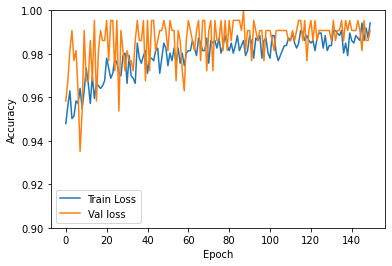

In [47]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0.9, 1])

plot_history(history)

### Model Prediction

In [48]:
# Predicting the output
def resize_img(image): 
  resized_image = np.zeros((32,32,3))
  for i in range(3):
    resized_image[:,:,i] = image
  return resized_image
  
def ch_predicted():
    ch_dict = {}
    charac_all = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i,c in enumerate(charac_all):
        ch_dict[i] = c

    output = []
    for i,ch in enumerate(ch_seg_copy): #iterating over the characters
        image = cv2.resize(ch, (32,32), interpolation=cv2.INTER_AREA)
        image = resize_img(image)
        image = image.reshape(1,32,32,3) #preparing image for the model
        prediction = model.predict(image)[0] #predicting the class
        y=np.argmax(prediction)

        predicted_character = ch_dict[y] #
        output.append(predicted_character) #storing the result in a list

    predicted_plate_number = ''.join(output)
    
    return predicted_plate_number

print(ch_predicted())

In [49]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(ch_seg_copy):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {ch_predicted()[i]}')
    plt.axis('off')
plt.show()

<Figure size 720x432 with 0 Axes>

## Model with more convolution and max pooling layers and BatchNormalization

In [51]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Conv2D(32,(3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3,3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
# Output classes are 36
model1.add(Dense(36))
model1.add(Activation('softmax'))


model1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [52]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 32)       

In [55]:
# class stop_training_callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_custom_f1score') > 0.99):
#       self.model.stop_training = True

In [56]:
batch_size = 1
# callbacks = [stop_training_callback()]
history1 = model1.fit_generator(
      train_generator,
      validation_data = valid_generator, 
      epochs = 80, verbose=1)

Epoch 1/80
864/864 [==============================] - 5s 6ms/step - loss: 1.1601 - accuracy: 0.6400 - val_loss: 0.6729 - val_accuracy: 0.7824
Epoch 2/80
864/864 [==============================] - 5s 6ms/step - loss: 0.7848 - accuracy: 0.7558 - val_loss: 0.4128 - val_accuracy: 0.8519
Epoch 3/80
864/864 [==============================] - 5s 6ms/step - loss: 0.6511 - accuracy: 0.7766 - val_loss: 0.3323 - val_accuracy: 0.8565
Epoch 4/80
864/864 [==============================] - 6s 7ms/step - loss: 0.4519 - accuracy: 0.8472 - val_loss: 0.3209 - val_accuracy: 0.9213
Epoch 5/80
864/864 [==============================] - 6s 7ms/step - loss: 0.4179 - accuracy: 0.8507 - val_loss: 0.2635 - val_accuracy: 0.9352
Epoch 6/80
864/864 [==============================] - 6s 7ms/step - loss: 0.3547 - accuracy: 0.8889 - val_loss: 0.1541 - val_accuracy: 0.9491
Epoch 7/80
864/864 [==============================] - 5s 6ms/step - loss: 0.3023 - accuracy: 0.8924 - val_loss: 0.2250 - val_accuracy: 0.9120
Epoch 

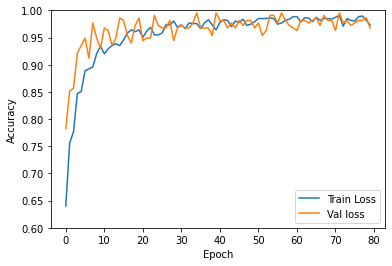

In [60]:
plot_history(history1)

## 

In [70]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(32,(3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model.add(Dropout(0.25))
model2.add(Dense(36))
model2.add(Activation('softmax'))


model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [71]:
# class stop_training_callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_custom_f1score') > 0.99):
#       self.model.stop_training = True

In [72]:
batch_size = 1
# callbacks = [stop_training_callback()]
history2 = model2.fit_generator(
      train_generator,
      validation_data = valid_generator, 
      epochs = 80, verbose=1)

Epoch 1/80
864/864 [==============================] - 6s 7ms/step - loss: 2.5628 - accuracy: 0.3183 - val_loss: 1.5276 - val_accuracy: 0.5787
Epoch 2/80
864/864 [==============================] - 6s 7ms/step - loss: 1.2878 - accuracy: 0.5822 - val_loss: 0.8001 - val_accuracy: 0.7500
Epoch 3/80
864/864 [==============================] - 6s 7ms/step - loss: 0.8488 - accuracy: 0.7303 - val_loss: 0.4874 - val_accuracy: 0.8611
Epoch 4/80
864/864 [==============================] - 6s 7ms/step - loss: 0.6656 - accuracy: 0.7766 - val_loss: 0.3977 - val_accuracy: 0.8796
Epoch 5/80
864/864 [==============================] - 6s 7ms/step - loss: 0.5466 - accuracy: 0.8322 - val_loss: 0.3692 - val_accuracy: 0.8750
Epoch 6/80
864/864 [==============================] - 7s 8ms/step - loss: 0.4651 - accuracy: 0.8553 - val_loss: 0.4068 - val_accuracy: 0.8657
Epoch 7/80
864/864 [==============================] - 6s 7ms/step - loss: 0.3930 - accuracy: 0.8681 - val_loss: 0.4446 - val_accuracy: 0.8750
Epoch 

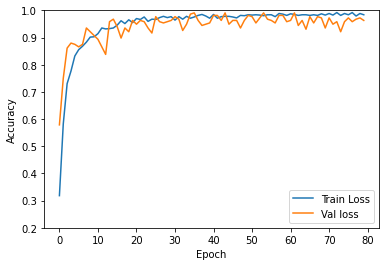

In [73]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0.2, 1])

plot_history(history2)